In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

import plotly.express as px
from plotly.subplots import make_subplots


import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)


/Users/xd/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/xd/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import ruptures as rpt
from scipy.interpolate import interp1d
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from joblib import dump, load


Cause we're treating stationary data as time series, we'll have an un-clustered global regression with sliding window features.

In [3]:
stationary_data = pd.read_csv("stationary_data.csv")

In [4]:
stationary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unit_Number                       20631 non-null  int64  
 1   Time_in_Cycles                    20631 non-null  int64  
 2   Operational_Setting_1             20631 non-null  float64
 3   Operational_Setting_2             20631 non-null  float64
 4   Operational_Setting_3             20631 non-null  float64
 5   Sensor_Measurement_1              20631 non-null  float64
 6   Sensor_Measurement_2              20631 non-null  float64
 7   Sensor_Measurement_3              20631 non-null  float64
 8   Sensor_Measurement_4              20631 non-null  float64
 9   Sensor_Measurement_5              20631 non-null  float64
 10  Sensor_Measurement_6              20631 non-null  float64
 11  Sensor_Measurement_7              20631 non-null  float64
 12  Sens

In [5]:
#global window regression 
features_draft = [col for col in stationary_data.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

X = stationary_data[features_draft]
y = stationary_data['RUL']


X_train_with_const = sm.add_constant(X)


linear_model = sm.OLS(y, X_train_with_const)
linear_model_fit = linear_model.fit()


print(linear_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     1344.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:01:24   Log-Likelihood:            -1.0541e+05
No. Observations:               20631   AIC:                         2.109e+05
Df Residuals:                   20600   BIC:                         2.111e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Time_in_

In [6]:
features_draft = [col for col in stationary_data.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

# Get the p-values from the fitted model
p_values = linear_model_fit.pvalues

# Filter for columns with p-value > 0.05
insignificant_features = p_values[p_values > 0.05].index.tolist()

features_draft = [col for col in features_draft if col not in insignificant_features]

t_stats = linear_model_fit.tvalues

# Sort the t-statistics by absolute value
sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

# Identify sensor-stationary pairs
sensor_pairs = []
for feature in t_stats_df['Feature']:
    if "_stationary" in feature:
        original = feature.replace("_stationary", "")
        if original in t_stats_df['Feature'].values:
            sensor_pairs.append((original, feature))


kept_features = []

for original, stationary in sensor_pairs:
    t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
    t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
    if abs(t_stationary) > abs(t_original):
        if original in features_draft: 
            features_draft.remove(original)
    else:
        if stationary in features_draft: features_draft.remove(stationary)

In [7]:
window_size = 20

# Create copies to store results
result_df = stationary_data.copy()

# Group the data by Unit_Number to calculate statistics separately for each unit
for feature in features_draft:
    if feature != "Time_in_Cycles":
        # Initialize empty lists to store the computed values
        means = []
        variances = []
        slopes = []

        # Process each unit separately
        for unit, group in stationary_data.groupby("Unit_Number"):
            group = group.sort_values("Time_in_Cycles")  # Ensure data is sorted by time

            # Initialize temporary lists for this feature and unit
            unit_means = []
            unit_variances = []
            unit_slopes = []

            # Iterate over rolling windows
            for i in range(len(group)):
                window = group.iloc[max(0, i - window_size + 1): i + 1]

                # Compute mean and variance
                unit_means.append(window[feature].mean())
                unit_variances.append(window[feature].var())

                # Compute slope if there's enough data
                if len(window) > 1:
                    slope, _, _, _, _ = linregress(window["Time_in_Cycles"], window[feature])
                    unit_slopes.append(slope)
                else:
                    unit_slopes.append(np.nan)

            # Append the computed results to the main lists
            means.extend(unit_means)
            variances.extend(unit_variances)
            slopes.extend(unit_slopes)

        # Add results to the DataFrame
        result_df[f"{feature}_mean"] = means
        result_df[f"{feature}_variance"] = variances
        result_df[f"{feature}_slope"] = slopes


In [8]:
print(result_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 83 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unit_Number                                20631 non-null  int64  
 1   Time_in_Cycles                             20631 non-null  int64  
 2   Operational_Setting_1                      20631 non-null  float64
 3   Operational_Setting_2                      20631 non-null  float64
 4   Operational_Setting_3                      20631 non-null  float64
 5   Sensor_Measurement_1                       20631 non-null  float64
 6   Sensor_Measurement_2                       20631 non-null  float64
 7   Sensor_Measurement_3                       20631 non-null  float64
 8   Sensor_Measurement_4                       20631 non-null  float64
 9   Sensor_Measurement_5                       20631 non-null  float64
 10  Sensor_Measurement_6  

In [9]:
features_draft = [col for col in result_df.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

result_df = result_df.fillna(0)

# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = result_df[features_draft]
    y = result_df['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values
    p_values = linear_model_fit2.pvalues
    
    # Identify features with p-values > 0.05
    insignificant_features = p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     828.8
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:02:52   Log-Likelihood:            -1.0494e+05
No. Observations:               20631   AIC:                         2.100e+05
Df Residuals:                   20578   BIC:                         2.104e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [10]:

# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "unclustered_regression_model_and_columns.joblib")

['unclustered_regression_model_and_columns.joblib']

In [11]:
def normalize_segment_length(segment, length=100):
    if len(segment) == 0:  # Handle empty segments
        return np.zeros(length)
    x = np.linspace(0, 1, len(segment))
    f = interp1d(x, segment, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, 1, length)
    return f(x_new)

# Initialize storage for normalized segments and mappings
normalized_segments = {}
segments_mapping = {}

# Features to segment and cluster
features = ['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']


# Loop through each feature
for feature in features:
    normalized_segments[feature] = []
    segments_mapping[feature] = []
    
    # Segment time series for each unit
    for unit in stationary_data['Unit_Number'].unique():
        # Extract unit data
        unit_data = stationary_data[stationary_data['Unit_Number'] == unit]
        
        # Scale the feature values
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(unit_data[feature].values.reshape(-1, 1)).flatten()
        
        # Detect change points using Ruptures
        model = rpt.Pelt(model="l2").fit(scaled_data)
        change_points = model.predict(pen=10)  # Adjust `pen` for granularity
        
        # Normalize each segment and store mapping information
        for start, end in zip([0] + change_points[:-1], change_points):
            segment = scaled_data[start:end]
            normalized_segment = normalize_segment_length(segment, length=100)
            
            normalized_segments[feature].append(normalized_segment)
            segments_mapping[feature].append({
                "unit_number": unit,
                "start_idx": start,
                "end_idx": end
            })

In [12]:

cluster_labels = {}
cluster_models = {}
k = 3  # Number of clusters (adjust as needed)

for feature, segments in normalized_segments.items():
    # Convert normalized segments to time-series dataset
    ts_data = to_time_series_dataset(segments)
    
    # Perform DTW clustering
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    labels = model.fit_predict(ts_data)
    
    # Store cluster labels and the trained model
    cluster_labels[feature] = labels
    cluster_models[feature] = model

In [13]:
model_save_path = "clustering_models"

# Save each clustering model in the cluster_models dictionary
for feature, model in cluster_models.items():
    model_filename = f"{model_save_path}/{feature}_clustering_model.pkl"
    dump(model, model_filename)
    
# # Load the saved clustering models
# loaded_cluster_models = {}

# for feature in normalized_segments.keys():
#     model_filename = f"{model_save_path}/{feature}_clustering_model.pkl"
#     loaded_cluster_models[feature] = joblib.load(model_filename)

In [14]:
# Create a mapping of cluster assignments to original rows
cluster_to_original_rows = {}

for feature, labels in cluster_labels.items():
    cluster_to_original_rows[feature] = []
    for i, label in enumerate(labels):
        metadata = segments_mapping[feature][i]
        unit_number = metadata["unit_number"]
        start_idx = metadata["start_idx"]
        end_idx = metadata["end_idx"]
        
        # Map each original row in the segment to the cluster
        cluster_to_original_rows[feature].append({
            "unit_number": unit_number,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "cluster": label
        })

In [15]:
def get_windowdf_rows_by_cluster(feature, cluster_id):
    original_rows = []
    for mapping in cluster_to_original_rows[feature]:
        if mapping["cluster"] == cluster_id:
            unit = mapping["unit_number"]
            start, end = mapping["start_idx"], mapping["end_idx"]
            
            # Retrieve the original rows for the segment
            rows = result_df[
                (result_df["Unit_Number"] == unit) &
                (result_df["Time_in_Cycles"] >= start) &
                (result_df["Time_in_Cycles"] < end)
            ]
            original_rows.append(rows)
    
    return pd.concat(original_rows)


In [16]:
print(features)

['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']


In [17]:
level2_models = {}

for cluster_feature in features:
    for cluster_number_id in range(3):
        
        cluster_rows = get_windowdf_rows_by_cluster(cluster_feature, cluster_number_id)

        features_draft = [col for col in cluster_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number','Time_in_Cycles_mean','Time_in_Cycles_variance','Time_in_Cycles_slope']]

        cluster_rows = cluster_rows.fillna(0)

        X = cluster_rows[features_draft]
        y = cluster_rows['RUL']
        X_train_with_const = sm.add_constant(X)


        linear_model = sm.OLS(y, X_train_with_const)
        linear_model_fit = linear_model.fit()

        # Get the p-values from the fitted model
        p_values = linear_model_fit.pvalues

        # Filter for columns with p-value > 0.05
        insignificant_features = p_values[p_values > 0.05].index.tolist()

        features_draft = [col for col in features_draft if col not in insignificant_features]

        t_stats = linear_model_fit.tvalues

        # Sort the t-statistics by absolute value
        sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

        filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
        t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

        # Identify sensor-stationary pairs
        sensor_pairs = []
        for feature in t_stats_df['Feature']:
            if "_stationary" in feature:
                original = feature.replace("_stationary", "")
                if original in t_stats_df['Feature'].values:
                    sensor_pairs.append((original, feature))


        kept_features = []

        for original, stationary in sensor_pairs:
            t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
            t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
            if abs(t_stationary) > abs(t_original):
                if original in features_draft: 
                    features_draft.remove(original)
            else:
                if stationary in features_draft: features_draft.remove(stationary)

        # Ensure this loop will refine features_draft until all p-values < 0.05
        while True:

            # Prepare the features (X) and target (y)
            X = cluster_rows[features_draft]
            y = cluster_rows['RUL']
            X_train_with_const = sm.add_constant(X)

            # Fit the linear model
            linear_model2 = sm.OLS(y, X_train_with_const)
            linear_model_fit2 = linear_model2.fit()

            # Get p-values
            p_values = linear_model_fit2.pvalues

            # Identify features with p-values > 0.05
            insignificant_features = p_values[p_values > 0.05].index.tolist()

            # Exclude 'const' from insignificant features if present
            insignificant_features = [col for col in insignificant_features if col != 'const']

            # Break the loop if there are no insignificant features
            if not insignificant_features:
                break

            # Update features_draft by removing insignificant features
            features_draft = [col for col in features_draft if col not in insignificant_features]

        level2_models[f'{cluster_feature},{cluster_number_id}'] = (linear_model_fit2,linear_model_fit2.summary())
        dump((linear_model_fit2, X_train_with_const.columns), f"FD001{cluster_feature}_c{cluster_number_id}_model_and_columns.joblib")


In [20]:
print(level2_models)

{'Operational_Setting_1,0': (<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fe0ec498c10>, <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     979.2
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:15:58   Log-Likelihood:                -26057.
No. Observations:                5613   AIC:                         5.217e+04
Df Residuals:                    5583   BIC:                         5.237e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                            

In [21]:
column_names_first_5 = ['Unit_Number', 'Time_in_Cycles', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3']

remaining_column_names = [f'Sensor_Measurement_{i}' for i in range(1,22)]

column_names = column_names_first_5 + remaining_column_names

test1 = pd.read_csv("test_FD001.txt", delim_whitespace=True, names=column_names)

In [30]:
def generate_remaining_columns(df):
    exponential_growth = ['Sensor_Measurement_2', 'Sensor_Measurement_3', 'Sensor_Measurement_4','Sensor_Measurement_8','Sensor_Measurement_11', 'Sensor_Measurement_12', 'Sensor_Measurement_13', 'Sensor_Measurement_15', 'Sensor_Measurement_17']
    logarithmic_decay = ['Sensor_Measurement_7','Sensor_Measurement_20', 'Sensor_Measurement_21']

    # Process exponential growth features
    for feature in exponential_growth:
        # Apply log transformation
        df[f"{feature}_stationary"] = np.log(df[feature])

    # Process logarithmic decay features
    for feature in logarithmic_decay:
        # Apply differencing 
        df[f"{feature}_stationary"] = df[feature].diff()

    
    rolling_columns = [
        'Sensor_Measurement_7', 'Sensor_Measurement_8', 'Sensor_Measurement_9',
        'Sensor_Measurement_13', 'Sensor_Measurement_14', 'Sensor_Measurement_20',
        'Sensor_Measurement_21','Sensor_Measurement_2_stationary', 'Sensor_Measurement_3_stationary',
        'Sensor_Measurement_4_stationary', 'Sensor_Measurement_11_stationary',
        'Sensor_Measurement_15_stationary', 'Sensor_Measurement_17_stationary','Operational_Setting_2'
    ]

    result = []
    window_size = 20

    for unit, group in df.groupby("Unit_Number"):
        group = group.sort_values("Time_in_Cycles")  # Ensure data is sorted by time

        for feature in rolling_columns:
            if feature in group.columns:
                # Initialize temporary lists for this feature and unit
                unit_means = []
                unit_variances = []
                unit_slopes = []

                # Iterate over rolling windows
                for i in range(len(group)):
                    window = group.iloc[max(0, i - window_size + 1): i + 1]

                    # Compute mean and variance
                    unit_means.append(window[feature].mean())
                    unit_variances.append(window[feature].var())

                    # Compute slope if there's enough data
                    if len(window) > 1:
                        slope, _, _, _, _ = linregress(window["Time_in_Cycles"], window[feature])
                        unit_slopes.append(slope)
                    else:
                        unit_slopes.append(np.nan)

                # Add new columns to the group
                group[f'{feature}_mean'] = unit_means
                group[f'{feature}_variance'] = unit_variances
                group[f'{feature}_slope'] = unit_slopes

        # Append the processed group to the result
        result.append(group)

    # Concatenate all processed groups back together
    final_df = pd.concat(result, axis=0).reset_index(drop=True)

    return final_df

In [31]:
test1_full = generate_remaining_columns(test1)

In [28]:
def assign_last_segment_to_cluster(test_data, features, cluster_models, segments_mapping):
    assigned_clusters = {}

    for feature in features:
        # Extract test data for the feature
        test_feature_data = test_data[feature].values

        # Scale the test feature
        scaler = StandardScaler()
        scaled_test_feature = scaler.fit_transform(test_feature_data.reshape(-1, 1)).flatten()

        # Detect change points using Ruptures
        model = rpt.Pelt(model="l2").fit(scaled_test_feature)
        change_points = model.predict(pen=10)  # Use the same penalty as training

        # Extract the last segment
        start_idx = change_points[-2] if len(change_points) > 1 else 0
        end_idx = len(scaled_test_feature)
        last_segment = scaled_test_feature[start_idx:end_idx]

        # Normalize the last segment
        normalized_last_segment = normalize_segment_length(last_segment, length=100)

        # Convert to the correct format for the model
        normalized_last_segment = normalized_last_segment.reshape(1, -1)

        # Assign the last segment to the closest cluster
        cluster_model = cluster_models[feature]
        cluster_label = cluster_model.predict(normalized_last_segment)[0]

        # Store the result
        assigned_clusters[feature] = {
            "cluster_label": cluster_label,
            "start_idx": start_idx,
            "end_idx": end_idx
        }

    return assigned_clusters

In [33]:
test_data = test1_full[test1_full["Unit_Number"] == 1]

assigned_clusters = assign_last_segment_to_cluster(
    test_data=test_data,
    features=['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary'],
    cluster_models=cluster_models,
    segments_mapping=segments_mapping
)


/Users/xd/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(
/Users/xd/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(
/Users/xd/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


In [34]:
print(assigned_clusters)

{'Operational_Setting_1': {'cluster_label': 2, 'start_idx': 0, 'end_idx': 31}, 'Operational_Setting_2': {'cluster_label': 2, 'start_idx': 0, 'end_idx': 31}, 'Sensor_Measurement_11_stationary': {'cluster_label': 0, 'start_idx': 0, 'end_idx': 31}}


In [108]:
def best_model_level2(assigned_clusters):
    best_model_key = (None,None)
    best_r2_value = float('-inf')
    best_model_details = None

    # Iterate through the assigned clusters
    for cluster_feature, details in assigned_clusters.items():
        # Access the cluster label
        cluster_number_id = details["cluster_label"]

        # Retrieve the corresponding model and summary from level2_models
        model_key = (cluster_feature,cluster_number_id)
        model_fit, summary = level2_models[f"{cluster_feature},{cluster_number_id}"]

        # Get the R^2 value
        r2_value = model_fit.rsquared

        # Update the best model if this R^2 is higher
        if r2_value > best_r2_value:
            best_r2_value = r2_value
            best_model_key = model_key
            best_model_details = (model_fit, summary)
    return best_model_key


In [114]:
import warnings

# Ignore specific warning from tslearn
warnings.filterwarnings("ignore", message="2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries")

# Ignore SettingWithCopyWarning globally
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


def test_dataset_fit(test_data_frame):
    RUL = []
    for unit_number, group in test_data_frame.groupby("Unit_Number"):
        
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]

        assigned_clusters = assign_last_segment_to_cluster(
            test_data=test_data,
            features=['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary'],
            cluster_models=cluster_models,
            segments_mapping=segments_mapping
        )
        
        cluster_feature,cluster_number_id = best_model_level2(assigned_clusters)
        
        filename = f"FD001{cluster_feature}_c{cluster_number_id}_model_and_columns.joblib"
        
        # Load the model and its columns
        linear_model_fit2, model_features = load(filename)
        
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]
        
        test_data.loc[:,'const'] = 1
        # Filter data to match model features
        filtered_data = test_data[model_features].fillna(0)
        
        y_train = []
        for i in range(1,11):
            filtered_data_with_const = filtered_data.iloc[-i]
            predictions = linear_model_fit2.predict(filtered_data_with_const)
            y_train.append(predictions)
        
        fit3 = SimpleExpSmoothing(y_train, initialization_method="estimated").fit()
        fcast3 = fit3.forecast(1)
        RUL.append(fcast3[0])
    return RUL
    
        
test1_RUL_Predict = test_dataset_fit(test1_full)

In [119]:
RUL_real = pd.read_csv("RUL_FD001.txt",names=['RUL'])  # Replace "file.csv" with your actual file path

# # Extract the integers into a list
RUL_real = RUL_real.iloc[:, 0].tolist()  # Assuming the integers are in the first column
print(RUL_real)

res = [a - b for a, b in zip(RUL_real, test1_RUL_Predict)]

print(res)

[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]
[-54.570643251217405, -54.494486551989326, -6.818254437852133, -21.61963648320672, -38.687158175143935, -21.660300467866918, -47.10617789259712, 8.779037076758257, 8.727219959816551, 21.407195265752705, -68.62843565200075, 30.595919340207445, 13.79385817534893, -12.751378953448295, -38.06684330410701, -42.399009433155356, -19.815499007910844, -8.049205951308053, -34.147746275682536, -11.225576666697538, -35.43936743542686, -39.638793298003804, 4.225996310174139, -26.711138132984246, -15.732330488593362, -38.32008856713401, -35.51059803309555, -1.197840046237431, -

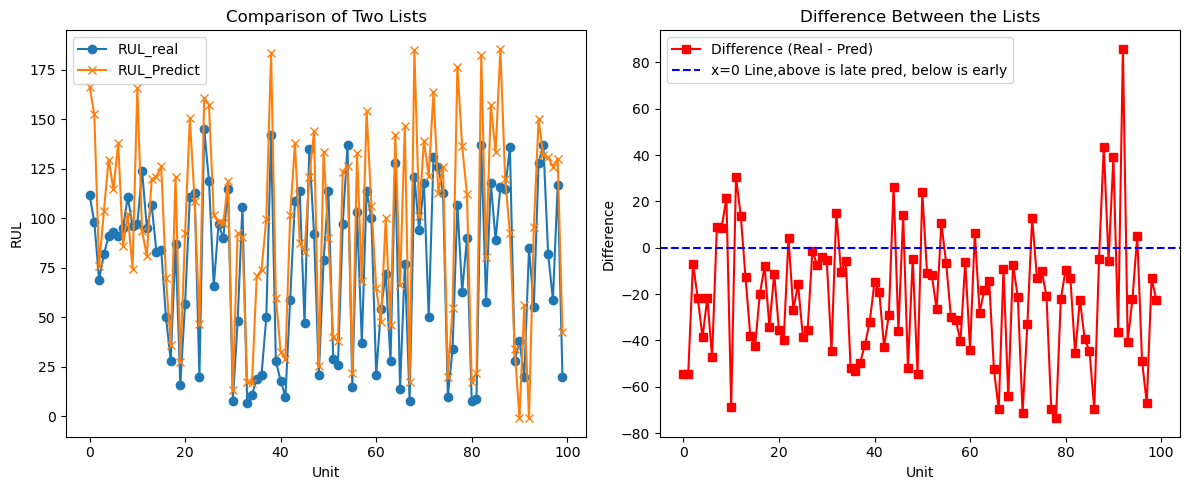

In [120]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the two lists against each other in the first subplot
axs[0].plot(RUL_real, label="RUL_real", marker='o')
axs[0].plot(test1_RUL_Predict, label="RUL_Predict", marker='x')
axs[0].set_title('Comparison of Two Lists')
axs[0].set_xlabel('Unit')
axs[0].set_ylabel('RUL')
axs[0].legend()

# Plot the difference in the second subplot
axs[1].plot(res, label="Difference (Real - Pred)", color='red', marker='s')
axs[1].axhline(0, color='blue', linestyle='--', label="x=0 Line,above is late pred, below is early")  # Add a horizontal line at x=0
axs[1].set_title('Difference Between the Lists')
axs[1].set_xlabel('Unit')
axs[1].set_ylabel('Difference')
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

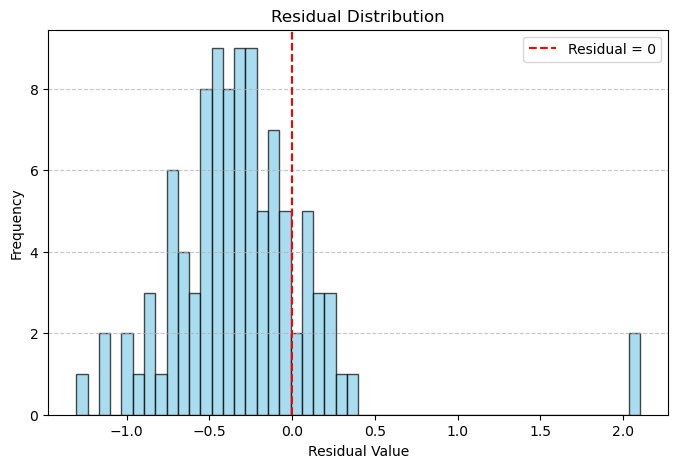

In [123]:
res_ratio = [(a - b)/((a+b)/2) for a, b in zip(RUL_real, test1_RUL_Predict)]

plt.figure(figsize=(8, 5))
plt.hist(res_ratio, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Residual = 0')  # Reference line at 0
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [124]:
def test_dataset_fit_without_ep(test_data_frame):
    RUL = []
    for unit_number, group in test_data_frame.groupby("Unit_Number"):
        
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]

        assigned_clusters = assign_last_segment_to_cluster(
            test_data=test_data,
            features=['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary'],
            cluster_models=cluster_models,
            segments_mapping=segments_mapping
        )
        
        cluster_feature,cluster_number_id = best_model_level2(assigned_clusters)
        
        filename = f"FD001{cluster_feature}_c{cluster_number_id}_model_and_columns.joblib"
        
        # Load the model and its columns
        linear_model_fit2, model_features = load(filename)
        
        test_data = test_data_frame[test_data_frame["Unit_Number"] == unit_number]
        
        test_data.loc[:,'const'] = 1
        # Filter data to match model features
        filtered_data = test_data[model_features].fillna(0)
        
        filtered_data_with_const = filtered_data.iloc[-1]
        predictions = linear_model_fit2.predict(filtered_data_with_const)
        RUL.append(predictions)
#         y_train = []
#         for i in range(1,11):
#             filtered_data_with_const = filtered_data.iloc[-i]
#             predictions = linear_model_fit2.predict(filtered_data_with_const)
#             y_train.append(predictions)
        
#         fit3 = SimpleExpSmoothing(y_train, initialization_method="estimated").fit()
#         fcast3 = fit3.forecast(1)
#         RUL.append(fcast3[0])
    return RUL
    
        
test1_RUL_Predict_2 = test_dataset_fit_without_ep(test1_full)


In [127]:
res_ratio2 = [(a - b)/((a+b)/2) for a, b in zip(RUL_real, test1_RUL_Predict_2)]


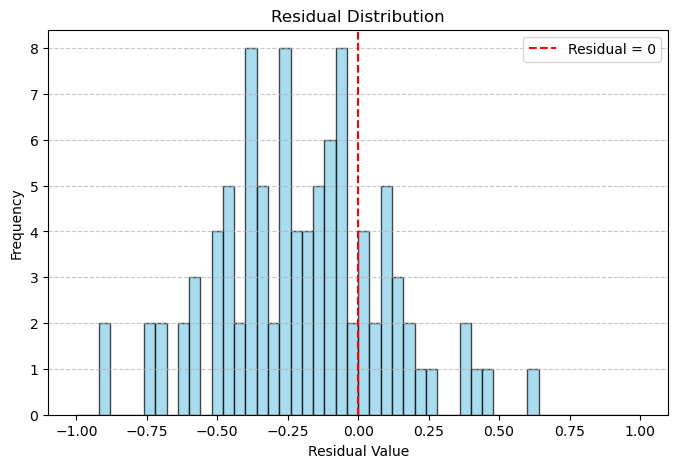

In [135]:
res_ratio2 = [float(x) for x in res_ratio2]  # Ensure it's a numeric 1D array

# Plot the histogram with adjustments
plt.figure(figsize=(8, 5))
plt.hist(res_ratio2, bins=50, range=(-1, 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Residual = 0')  # Reference line at 0
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [11]:
cluster_0_rows = get_original_rows_by_cluster("Operational_Setting_1", 0)
print(cluster_0_rows.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5613 entries, 847 to 20244
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unit_Number                       5613 non-null   int64  
 1   Time_in_Cycles                    5613 non-null   int64  
 2   Operational_Setting_1             5613 non-null   float64
 3   Operational_Setting_2             5613 non-null   float64
 4   Operational_Setting_3             5613 non-null   float64
 5   Sensor_Measurement_1              5613 non-null   float64
 6   Sensor_Measurement_2              5613 non-null   float64
 7   Sensor_Measurement_3              5613 non-null   float64
 8   Sensor_Measurement_4              5613 non-null   float64
 9   Sensor_Measurement_5              5613 non-null   float64
 10  Sensor_Measurement_6              5613 non-null   float64
 11  Sensor_Measurement_7              5613 non-null   float64
 12  Sensor_M

In [12]:


features_draft = [col for col in cluster_0_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

X = stationary_data[features_draft]
y = stationary_data['RUL']


X_train_with_const = sm.add_constant(X)


linear_model = sm.OLS(y, X_train_with_const)
linear_model_fit = linear_model.fit()


print(linear_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     1344.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:07:14   Log-Likelihood:            -1.0541e+05
No. Observations:               20631   AIC:                         2.109e+05
Df Residuals:                   20600   BIC:                         2.111e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Time_in_

In [13]:
features_draft = [col for col in cluster_0_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number']]

# Get the p-values from the fitted model
p_values = linear_model_fit.pvalues

# Filter for columns with p-value > 0.05
insignificant_features = p_values[p_values > 0.05].index.tolist()

features_draft = [col for col in features_draft if col not in insignificant_features]

t_stats = linear_model_fit.tvalues

# Sort the t-statistics by absolute value
sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

# Identify sensor-stationary pairs
sensor_pairs = []
for feature in t_stats_df['Feature']:
    if "_stationary" in feature:
        original = feature.replace("_stationary", "")
        if original in t_stats_df['Feature'].values:
            sensor_pairs.append((original, feature))


kept_features = []

for original, stationary in sensor_pairs:
    t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
    t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
    if abs(t_stationary) > abs(t_original):
        if original in features_draft: 
            features_draft.remove(original)
    else:
        if stationary in features_draft: features_draft.remove(stationary)


In [16]:
from scipy.stats import linregress
window_size = 20

# Create copies to store results
result_df = stationary_data.copy()

# Group the data by Unit_Number to calculate statistics separately for each unit
for feature in features_draft:
    # Initialize empty lists to store the computed values
    means = []
    variances = []
    slopes = []

    # Process each unit separately
    for unit, group in stationary_data.groupby("Unit_Number"):
        group = group.sort_values("Time_in_Cycles")  # Ensure data is sorted by time

        # Initialize temporary lists for this feature and unit
        unit_means = []
        unit_variances = []
        unit_slopes = []

        # Iterate over rolling windows
        for i in range(len(group)):
            window = group.iloc[max(0, i - window_size + 1): i + 1]

            # Compute mean and variance
            unit_means.append(window[feature].mean())
            unit_variances.append(window[feature].var())

            # Compute slope if there's enough data
            if len(window) > 1:
                slope, _, _, _, _ = linregress(window["Time_in_Cycles"], window[feature])
                unit_slopes.append(slope)
            else:
                unit_slopes.append(np.nan)

        # Append the computed results to the main lists
        means.extend(unit_means)
        variances.extend(unit_variances)
        slopes.extend(unit_slopes)

    # Add results to the DataFrame
    result_df[f"{feature}_mean"] = means
    result_df[f"{feature}_variance"] = variances
    result_df[f"{feature}_slope"] = slopes


In [17]:
def get_windowdf_rows_by_cluster(feature, cluster_id):
    original_rows = []
    for mapping in cluster_to_original_rows[feature]:
        if mapping["cluster"] == cluster_id:
            unit = mapping["unit_number"]
            start, end = mapping["start_idx"], mapping["end_idx"]
            
            # Retrieve the original rows for the segment
            rows = result_df[
                (result_df["Unit_Number"] == unit) &
                (result_df["Time_in_Cycles"] >= start) &
                (result_df["Time_in_Cycles"] < end)
            ]
            original_rows.append(rows)
    
    return pd.concat(original_rows)

cluster_0_rows = get_windowdf_rows_by_cluster("Operational_Setting_1", 0)

In [18]:
print(cluster_0_rows.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5613 entries, 847 to 20244
Data columns (total 86 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unit_Number                                5613 non-null   int64  
 1   Time_in_Cycles                             5613 non-null   int64  
 2   Operational_Setting_1                      5613 non-null   float64
 3   Operational_Setting_2                      5613 non-null   float64
 4   Operational_Setting_3                      5613 non-null   float64
 5   Sensor_Measurement_1                       5613 non-null   float64
 6   Sensor_Measurement_2                       5613 non-null   float64
 7   Sensor_Measurement_3                       5613 non-null   float64
 8   Sensor_Measurement_4                       5613 non-null   float64
 9   Sensor_Measurement_5                       5613 non-null   float64
 10  Sensor_Measurement_6      

In [19]:
print(features_draft)

['Time_in_Cycles', 'Operational_Setting_2', 'Sensor_Measurement_7', 'Sensor_Measurement_8', 'Sensor_Measurement_9', 'Sensor_Measurement_13', 'Sensor_Measurement_14', 'Sensor_Measurement_20', 'Sensor_Measurement_21', 'Sensor_Measurement_2_stationary', 'Sensor_Measurement_3_stationary', 'Sensor_Measurement_4_stationary', 'Sensor_Measurement_11_stationary', 'Sensor_Measurement_15_stationary', 'Sensor_Measurement_17_stationary']


In [20]:
extra_columns = [
    f"{feature}_{stat}" 
    for feature in features_draft if feature != "Time_in_Cycles"
    for stat in ["mean", "variance", "slope"]
]
features_draft += extra_columns

In [21]:
extra_columns = [
    f"{feature}_{stat}" 
    for feature in features_draft if feature != "Time_in_Cycles"
    for stat in ["mean", "variance", "slope"]
]
features_draft += extra_columns

cluster_0_rows = cluster_0_rows.fillna(0)

# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = cluster_0_rows[features_draft]
    y = cluster_0_rows['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values
    p_values = linear_model_fit2.pvalues
    
    # Identify features with p-values > 0.05
    insignificant_features = p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

    
print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1281.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:10:26   Log-Likelihood:                -26078.
No. Observations:                5613   AIC:                         5.220e+04
Df Residuals:                    5590   BIC:                         5.235e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [22]:
#naive model:linear_model_fit3
from joblib import dump, load

# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "Operational_Setting_1_c0_model_and_columns.joblib")

['Operational_Setting_1_c0_model_and_columns.joblib']

In [23]:
cluster_1_rows = get_windowdf_rows_by_cluster("Operational_Setting_1", 1)

print(cluster_1_rows.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7074 entries, 1563 to 20629
Data columns (total 86 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unit_Number                                7074 non-null   int64  
 1   Time_in_Cycles                             7074 non-null   int64  
 2   Operational_Setting_1                      7074 non-null   float64
 3   Operational_Setting_2                      7074 non-null   float64
 4   Operational_Setting_3                      7074 non-null   float64
 5   Sensor_Measurement_1                       7074 non-null   float64
 6   Sensor_Measurement_2                       7074 non-null   float64
 7   Sensor_Measurement_3                       7074 non-null   float64
 8   Sensor_Measurement_4                       7074 non-null   float64
 9   Sensor_Measurement_5                       7074 non-null   float64
 10  Sensor_Measurement_6     

In [24]:
features_draft = [col for col in cluster_1_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number','Time_in_Cycles_mean','Time_in_Cycles_variance','Time_in_Cycles_slope']]

cluster_1_rows = cluster_1_rows.fillna(0)

X = cluster_1_rows[features_draft]
y = cluster_1_rows['RUL']

X_train_with_const = sm.add_constant(X)


linear_model = sm.OLS(y, X_train_with_const)
linear_model_fit = linear_model.fit()

# Get the p-values from the fitted model
p_values = linear_model_fit.pvalues

# Filter for columns with p-value > 0.05
insignificant_features = p_values[p_values > 0.05].index.tolist()

features_draft = [col for col in features_draft if col not in insignificant_features]

t_stats = linear_model_fit.tvalues

# Sort the t-statistics by absolute value
sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

# Identify sensor-stationary pairs
sensor_pairs = []
for feature in t_stats_df['Feature']:
    if "_stationary" in feature:
        original = feature.replace("_stationary", "")
        if original in t_stats_df['Feature'].values:
            sensor_pairs.append((original, feature))


kept_features = []

for original, stationary in sensor_pairs:
    t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
    t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
    if abs(t_stationary) > abs(t_original):
        if original in features_draft: 
            features_draft.remove(original)
    else:
        if stationary in features_draft: features_draft.remove(stationary)


In [25]:
# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = cluster_1_rows[features_draft]
    y = cluster_1_rows['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values
    p_values = linear_model_fit2.pvalues
    
    # Identify features with p-values > 0.05
    insignificant_features = p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

    
print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     475.4
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:13:24   Log-Likelihood:                -36143.
No. Observations:                7074   AIC:                         7.236e+04
Df Residuals:                    7039   BIC:                         7.260e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [26]:
# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "Operational_Setting_1_c1_model_and_columns.joblib")

['Operational_Setting_1_c1_model_and_columns.joblib']

In [27]:
cluster_2_rows = get_windowdf_rows_by_cluster("Operational_Setting_1", 2)
print(cluster_2_rows.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7844 entries, 0 to 20429
Data columns (total 86 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unit_Number                                7844 non-null   int64  
 1   Time_in_Cycles                             7844 non-null   int64  
 2   Operational_Setting_1                      7844 non-null   float64
 3   Operational_Setting_2                      7844 non-null   float64
 4   Operational_Setting_3                      7844 non-null   float64
 5   Sensor_Measurement_1                       7844 non-null   float64
 6   Sensor_Measurement_2                       7844 non-null   float64
 7   Sensor_Measurement_3                       7844 non-null   float64
 8   Sensor_Measurement_4                       7844 non-null   float64
 9   Sensor_Measurement_5                       7844 non-null   float64
 10  Sensor_Measurement_6        

In [28]:
features_draft = [col for col in cluster_2_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number','Time_in_Cycles_mean','Time_in_Cycles_variance','Time_in_Cycles_slope']]

cluster_2_rows = cluster_2_rows.fillna(0)

X = cluster_2_rows[features_draft]
y = cluster_2_rows['RUL']

X_train_with_const = sm.add_constant(X)


linear_model = sm.OLS(y, X_train_with_const)
linear_model_fit = linear_model.fit()

# Get the p-values from the fitted model
p_values = linear_model_fit.pvalues

# Filter for columns with p-value > 0.05
insignificant_features = p_values[p_values > 0.05].index.tolist()

features_draft = [col for col in features_draft if col not in insignificant_features]

t_stats = linear_model_fit.tvalues

# Sort the t-statistics by absolute value
sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

# Identify sensor-stationary pairs
sensor_pairs = []
for feature in t_stats_df['Feature']:
    if "_stationary" in feature:
        original = feature.replace("_stationary", "")
        if original in t_stats_df['Feature'].values:
            sensor_pairs.append((original, feature))


kept_features = []

for original, stationary in sensor_pairs:
    t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
    t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
    if abs(t_stationary) > abs(t_original):
        if original in features_draft: 
            features_draft.remove(original)
    else:
        if stationary in features_draft: features_draft.remove(stationary)

# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = cluster_2_rows[features_draft]
    y = cluster_2_rows['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values
    p_values = linear_model_fit2.pvalues
    
    # Identify features with p-values > 0.05
    insignificant_features = p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

    
print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     349.8
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:15:52   Log-Likelihood:                -40417.
No. Observations:                7844   AIC:                         8.091e+04
Df Residuals:                    7805   BIC:                         8.118e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [29]:
# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "Operational_Setting_1_c2_model_and_columns.joblib")

['Operational_Setting_1_c2_model_and_columns.joblib']

In [33]:
for cluset_feature in 

cluster_3_rows = get_windowdf_rows_by_cluster("Operational_Setting_2", 0)

features_draft = [col for col in cluster_2_rows.columns if col not in ['Max_Life', 'RUL', 'normalized_time','Unit_Number','Time_in_Cycles_mean','Time_in_Cycles_variance','Time_in_Cycles_slope']]

cluster_3_rows = cluster_3_rows.fillna(0)

X = cluster_3_rows[features_draft]
y = cluster_3_rows['RUL']

X_train_with_const = sm.add_constant(X)


linear_model = sm.OLS(y, X_train_with_const)
linear_model_fit = linear_model.fit()

# Get the p-values from the fitted model
p_values = linear_model_fit.pvalues

# Filter for columns with p-value > 0.05
insignificant_features = p_values[p_values > 0.05].index.tolist()

features_draft = [col for col in features_draft if col not in insignificant_features]

t_stats = linear_model_fit.tvalues

# Sort the t-statistics by absolute value
sorted_features_by_tstat = t_stats.abs().sort_values(ascending=False)

filtered_t_stats = {key: value for key, value in t_stats.items() if key in features_draft}
t_stats_df = pd.DataFrame(list(filtered_t_stats.items()), columns=["Feature", "T_Value"])

# Identify sensor-stationary pairs
sensor_pairs = []
for feature in t_stats_df['Feature']:
    if "_stationary" in feature:
        original = feature.replace("_stationary", "")
        if original in t_stats_df['Feature'].values:
            sensor_pairs.append((original, feature))


kept_features = []

for original, stationary in sensor_pairs:
    t_original = t_stats_df.loc[t_stats_df['Feature'] == original, 'T_Value'].values[0]
    t_stationary = t_stats_df.loc[t_stats_df['Feature'] == stationary, 'T_Value'].values[0]
    if abs(t_stationary) > abs(t_original):
        if original in features_draft: 
            features_draft.remove(original)
    else:
        if stationary in features_draft: features_draft.remove(stationary)

# Ensure this loop will refine features_draft until all p-values < 0.05
while True:
    
    # Prepare the features (X) and target (y)
    X = cluster_3_rows[features_draft]
    y = cluster_3_rows['RUL']
    
    # Add a constant to the features for the intercept
    X_train_with_const = sm.add_constant(X)
    
    # Fit the linear model
    linear_model2 = sm.OLS(y, X_train_with_const)
    linear_model_fit2 = linear_model2.fit()
    
    # Get p-values
    p_values = linear_model_fit2.pvalues
    
    # Identify features with p-values > 0.05
    insignificant_features = p_values[p_values > 0.05].index.tolist()
    
    # Exclude 'const' from insignificant features if present
    insignificant_features = [col for col in insignificant_features if col != 'const']
    
    # Break the loop if there are no insignificant features
    if not insignificant_features:
        break
    
    # Update features_draft by removing insignificant features
    features_draft = [col for col in features_draft if col not in insignificant_features]
    

    
print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     581.0
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:35:57   Log-Likelihood:                -51247.
No. Observations:               10041   AIC:                         1.026e+05
Df Residuals:                   10004   BIC:                         1.028e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [ ]:
# Save the model and preprocessed data
dump((linear_model_fit2, X_train_with_const.columns), "Operational_Setting_2_c0_model_and_columns.joblib")

In [52]:
cluster_0_rows = cluster_0_rows.fillna(0)
X = cluster_0_rows[features_draft]
y = cluster_0_rows['RUL']


X_train_with_const = sm.add_constant(X)


linear_model2 = sm.OLS(y, X_train_with_const)
linear_model_fit2 = linear_model2.fit()


print(linear_model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1281.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:23:44   Log-Likelihood:                -26078.
No. Observations:                5613   AIC:                         5.220e+04
Df Residuals:                    5590   BIC:                         5.235e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [5]:
segments_per_feature = {
    'Operational_Setting_1': [],
    'Operational_Setting_2': [],
    'Sensor_Measurement_11_stationary': []
}

# Extract segments for clustering
for unit, segment_info in segments.items():
    data = segment_info['data']
    change_points = segment_info['change_points']
    
    # For each feature
    for i, feature in enumerate(['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']):
        # Extract segments between change points
        feature_segments = [data[start:end, i] for start, end in zip([0] + change_points[:-1], change_points)]
        segments_per_feature[feature].extend(feature_segments)

In [13]:
from collections import Counter
sizes = [len(segments_per_feature['Sensor_Measurement_11_stationary'][i]) for i in range(len(segments_per_feature['Sensor_Measurement_11_stationary']))]

print(len(Counter(sizes).keys()))
print(sizes)

63
[100, 30, 35, 27, 45, 95, 70, 45, 32, 40, 75, 40, 24, 125, 40, 24, 160, 60, 35, 14, 115, 45, 28, 135, 75, 49, 40, 60, 25, 10, 15, 120, 10, 30, 25, 16, 75, 75, 40, 32, 140, 50, 25, 25, 80, 45, 25, 20, 100, 45, 18, 70, 60, 40, 10, 15, 110, 55, 27, 135, 45, 29, 175, 60, 15, 26, 125, 40, 20, 10, 95, 45, 18, 115, 75, 44, 80, 60, 35, 20, 105, 65, 32, 110, 25, 33, 70, 55, 22, 140, 45, 25, 20, 110, 20, 30, 39, 100, 40, 16, 35, 65, 40, 25, 65, 65, 33, 90, 55, 30, 19, 130, 10, 60, 34, 60, 70, 30, 31, 5, 80, 65, 20, 30, 75, 80, 30, 10, 105, 40, 36, 75, 5, 45, 33, 100, 25, 20, 25, 135, 35, 24, 55, 25, 30, 18, 100, 30, 35, 23, 140, 25, 35, 16, 110, 55, 31, 130, 35, 20, 22, 110, 40, 30, 12, 90, 45, 23, 135, 50, 45, 26, 80, 35, 40, 40, 19, 125, 50, 35, 21, 120, 40, 35, 20, 95, 65, 38, 150, 40, 23, 105, 55, 25, 28, 120, 40, 5, 15, 15, 135, 70, 30, 22, 125, 50, 18, 165, 45, 40, 25, 50, 40, 30, 17, 45, 35, 35, 20, 12, 135, 40, 35, 21, 125, 30, 17, 90, 45, 35, 15, 95, 50, 25, 10, 60, 75, 35, 4, 140, 6

In [7]:
from scipy.interpolate import interp1d
import numpy as np

# Function to normalize segment lengths
def normalize_segment_length(segment, length=100):
    if len(segment) == 0:  # Handle empty segments
        return np.zeros(length)
    x = np.linspace(0, 1, len(segment))
    f = interp1d(x, segment, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, 1, length)
    return f(x_new)

# Normalize segments for each feature
# normalized_segments = {
#     feature: [normalize_segment_length(seg, length=100) for seg in seg_list]
#     for feature, seg_list in segments_per_feature.items()
# }

In [14]:
# Normalize segments for each feature
segments_mapping = {
    feature: {
        "original": seg_list,  # Original un-normalized segments
        "normalized": [normalize_segment_length(seg, length=100) for seg in seg_list]  # Normalized segments
    }
    for feature, seg_list in segments_per_feature.items()
}

In [15]:
#clustering using dtw

cluster_labels_original = {}
cluster_models = {}

for feature, mapping in segments_mapping.items():
    # Convert normalized segments to time-series dataset
    ts_data = to_time_series_dataset(mapping["normalized"])
    
    # Perform clustering
    k = 3  # Number of clusters
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    labels = model.fit_predict(ts_data)
    
    # Store cluster labels for original segments
    cluster_labels_original[feature] = labels
    
    cluster_models[feature] = model

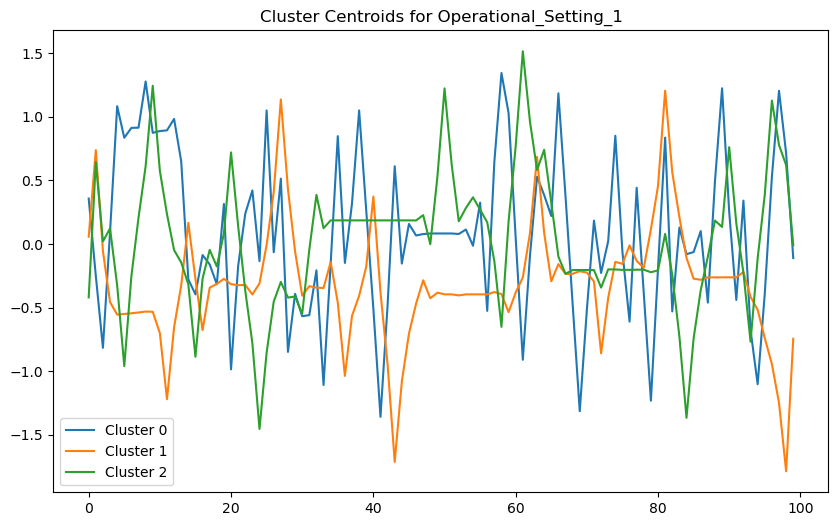

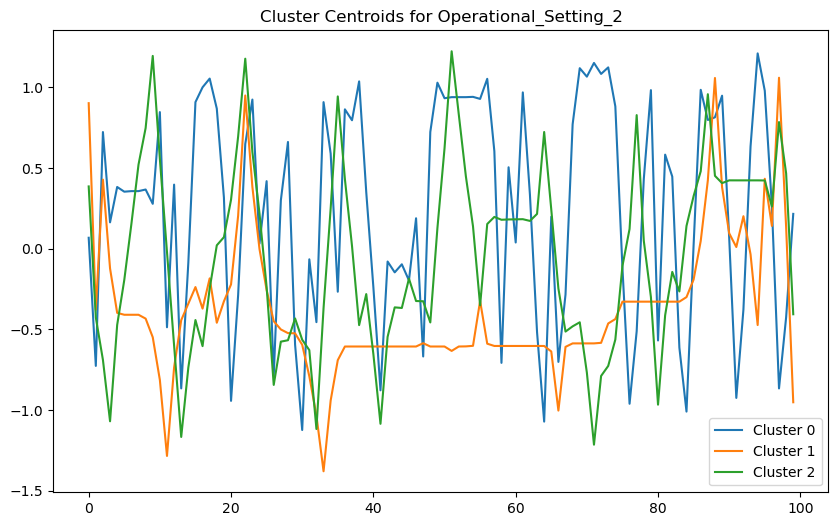

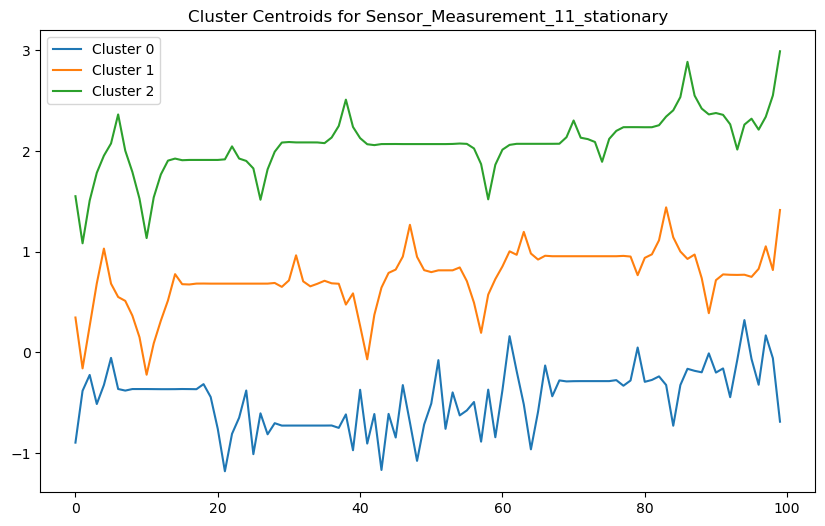

In [16]:
for feature, model in cluster_models.items():
    plt.figure(figsize=(10, 6))
    for i, centroid in enumerate(model.cluster_centers_):
        plt.plot(centroid.ravel(), label=f"Cluster {i}")
    plt.title(f"Cluster Centroids for {feature}")
    plt.legend()
    plt.show()

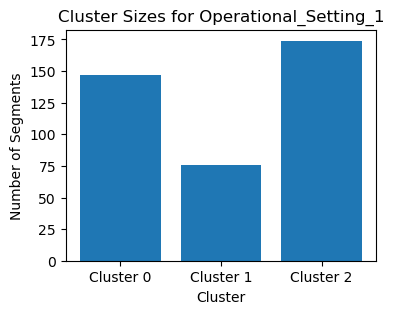

Cluster sizes for Operational_Setting_1:
  Cluster 0: 147 segments
  Cluster 1: 76 segments
  Cluster 2: 174 segments


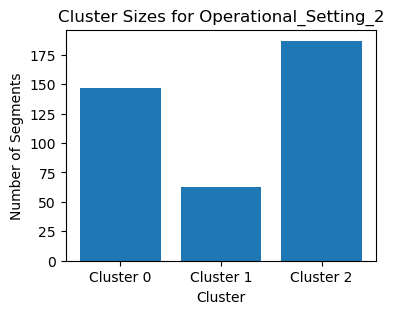

Cluster sizes for Operational_Setting_2:
  Cluster 0: 147 segments
  Cluster 1: 63 segments
  Cluster 2: 187 segments


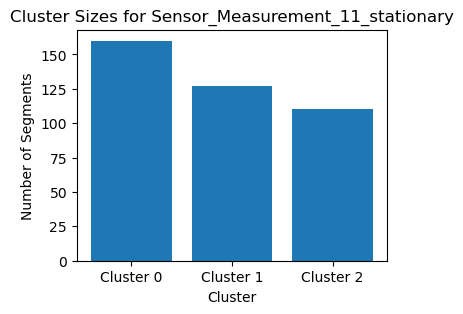

Cluster sizes for Sensor_Measurement_11_stationary:
  Cluster 0: 160 segments
  Cluster 1: 127 segments
  Cluster 2: 110 segments


In [21]:
for feature, labels in cluster_labels.items():
    # Count the number of segments in each cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    
    plt.figure(figsize=(4, 3))
    plt.bar(unique, counts, tick_label=[f"Cluster {i}" for i in unique])
    plt.title(f"Cluster Sizes for {feature}")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Segments")
    plt.show()
    
    # Print the cluster sizes
    print(f"Cluster sizes for {feature}:")
    for cluster, size in cluster_sizes.items():
        print(f"  Cluster {cluster}: {size} segments")

In [17]:
# Function to retrieve original segments by cluster
def get_segments_by_cluster(feature, cluster_id):
    labels = cluster_labels_original[feature]
    original_segments = segments_mapping[feature]["original"]
    return [original_segments[i] for i, label in enumerate(labels) if label == cluster_id]


In [18]:
feature = "Operational_Setting_1"
cluster_id = 0
segments_in_cluster_0 = get_segments_by_cluster(feature, cluster_id)

print(f"Number of segments in Cluster {cluster_id} for {feature}: {len(segments_in_cluster_0)}")

Number of segments in Cluster 0 for Operational_Setting_1: 147


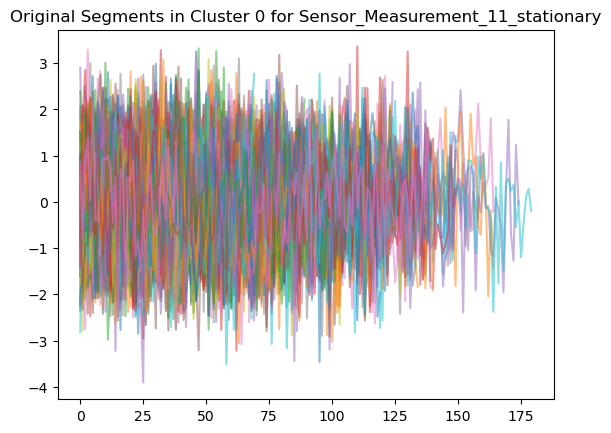

In [22]:
for seg in segments_in_cluster_0:
    plt.plot(seg, alpha=0.5)  # Plot each segment with slight transparency
plt.title(f"Original Segments in Cluster {cluster_id} for {feature}")
plt.show()

In [23]:
print(segments_in_cluster_0[0])

[-0.26224076  1.07221987 -2.10995549  0.45631497 -0.87814567 -2.10995549
  0.61029119 -1.64802681  0.50764037 -1.5967014   1.02089447  0.91824365
 -0.87814567  0.55896578 -0.82682026  0.40498956  0.19968792 -1.49405058
  1.73945019 -1.80200304 -0.51886781  0.19968792  1.84210101 -0.41621699
  1.27752151  0.0970371  -0.51886781 -1.13477272  0.71294201 -1.0321219
  0.81559283  0.35366415 -2.05863008  0.86691824  0.25101333 -0.10826453
 -0.10826453 -0.82682026 -1.44272517  0.0970371   1.7907756   0.35366415
 -1.28874894  0.04571169 -0.57019322  0.25101333  0.0970371   1.07221987
 -0.62151863 -1.54537599 -0.41621699  1.02089447  1.17487069 -0.00561372
  0.55896578  0.45631497 -1.5967014  -0.62151863 -0.21091535 -0.41621699
  0.30233874  0.30233874  0.86691824  0.96956906  0.0970371  -0.26224076
  0.91824365 -0.82682026 -1.0321219  -0.15958994  0.91824365 -0.77549485
 -0.51886781  1.48282315  0.55896578 -0.67284404  1.2261961   2.15005347
  1.2261961  -0.00561372 -0.82682026 -0.51886781  0.

In [ ]:
#clustering using segment mean,variance,slope,size
from scipy.stats import linregress

In [ ]:
stationary_data = pd.read_csv("stationary_data.csv")

In [ ]:
segments_mapping = {}  # To store segment information for each feature
for feature in ['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']:
    segments_mapping[feature] = []  # Store segments for each feature

for unit in segment_related_features['Unit_Number'].unique():
    unit_data = segment_related_features[segment_related_features['Unit_Number'] == unit]
    scaler = StandardScaler()
    scaled_op_settings = scaler.fit_transform(unit_data[['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']])
    
    # Segment the data using Ruptures
    model = rpt.Pelt(model="l2").fit(scaled_op_settings)
    change_points = model.predict(pen=10)
    
    # Save segments with start/end indices
    for feature_idx, feature in enumerate(['Operational_Setting_1', 'Operational_Setting_2', 'Sensor_Measurement_11_stationary']):
        for start, end in zip([0] + change_points[:-1], change_points):
            segments_mapping[feature].append({
                "unit_number": unit,
                "start_idx": start,
                "end_idx": end,
                "segment": scaled_op_settings[start:end, feature_idx]
            })

In [ ]:
for feature in segments_mapping.keys():
    for segment_info in segments_mapping[feature]:
        segment = segment_info["segment"]
        
        # Extract features
        mean = np.mean(segment)
        variance = np.var(segment)
        slope, _, _, _, _ = linregress(np.arange(len(segment)), segment)
        
        # Add features to the segment info
        segment_info["features"] = [mean, variance, slope]

In [ ]:
cluster_labels = {}
k = 3  # Number of clusters

for feature in segments_mapping.keys():
    # Prepare feature matrix
    feature_matrix = np.array([seg["features"] for seg in segments_mapping[feature]])
    
    # Perform clustering
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(feature_matrix)
    
    # Assign cluster labels back to the segment info
    for i, seg in enumerate(segments_mapping[feature]):
        seg["cluster"] = labels[i]
    
    # Store labels for each feature
    cluster_labels[feature] = labels

In [ ]:
data_point_clusters = []  # To store cluster assignment for each data point
for feature in segments_mapping.keys():
    for seg in segments_mapping[feature]:
        unit = seg["unit_number"]
        cluster = seg["cluster"]
        start, end = seg["start_idx"], seg["end_idx"]
        
        # Map each data point in the segment to the cluster
        for i in range(start, end):
            data_point_clusters.append({
                "unit_number": unit,
                "time_in_cycles": i,
                "feature": feature,
                "cluster": cluster
            })

In [ ]:
regression_models = {}  # Store regression models for each cluster

for feature in cluster_labels.keys():
    for cluster_id in range(k):
        # Filter data points belonging to the cluster
        cluster_data = [
            dp for dp in data_point_clusters if dp["feature"] == feature and dp["cluster"] == cluster_id
        ]
        
        # Retrieve corresponding rows from the original dataset
        X = []  # Features
        y = []  # RUL (target)
        for dp in cluster_data:
            unit = dp["unit_number"]
            time = dp["time_in_cycles"]
            original_row = stationary_data[
                (stationary_data["Unit_Number"] == unit) &
                (stationary_data["Time_in_Cycles"] == time)
            ]
            X.append(original_row.drop(["RUL", "Unit_Number", "Time_in_Cycles"], axis=1).values[0])
            y.append(original_row["RUL"].values[0])
        
        # Train the regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Store the model
        regression_models[(feature, cluster_id)] = model

In [ ]:
def predict_rul(test_segment, feature, cluster_models, regression_models):
    # Extract features from the test segment
    mean = np.mean(test_segment)
    variance = np.var(test_segment)
    slope, _, _, _, _ = linregress(np.arange(len(test_segment)), test_segment)
    test_features = [mean, variance, slope]
    
    # Find the closest cluster
    cluster_model = cluster_models[feature]
    cluster = cluster_model.predict([test_features])[0]
    
    # Predict RUL using the regression model for the cluster
    regression_model = regression_models[(feature, cluster)]
    return regression_model.predict([test_features])[0]